In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from pathlib import Path
from scipy import stats
from functools import partial
from itertools import combinations
from typing import Iterable

In [2]:
[f.name for f in Path('../datasets').glob('*.*')]

['metadata.txt', 'test.csv', 'train.csv']

In [3]:
pd.set_option('display.max_columns', 80)

In [4]:
sns.set_theme()

In [5]:
so.Plot.config.theme['figure.constrained_layout.use'] = True

In [6]:
def set_headers(df: pd.DataFrame, headers: Iterable[str | int | float]) -> pd.DataFrame:
    df.columns = headers
    return df

# Loading df

In [7]:
dummied_cols = ['MSSubClass']
date_frag_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

In [8]:
na_fill_mapping = {
    'Alley': 'NAcc',
    'BsmtQual': 'NBsmt',
    'BsmtCond': 'NBsmt',
    'BsmtExposure': 'NBsmt',
    'BsmtFinType1': 'NBsmt',
    'BsmtFinType2': 'NBsmt',
    'FireplaceQu': 'NFp',
    'GarageType': 'NGa',
    'GarageFinish': 'NGa',
    'GarageQual': 'NGa',
    'GarageCond': 'NGa',
    'PoolQC': 'NPo',
    'Fence': 'NFe',
    'MiscFeature': 'None',
    'MasVnrType': 'None',
}

In [9]:
def read_house_dataset(filepath, **kwargs) -> pd.DataFrame:
    df = (
        pd.read_csv(
            filepath, 
            index_col=0,
            **kwargs,
        )
        .fillna(na_fill_mapping)  # applying fillna so that variables where nans mean something get filled in.
        .astype({col:'str' for col in dummied_cols})  # converting encoded to str so that we can clearly distinguish 
                                                      # between qualitative and quantitative variables.
                                                      # decided to keep grading variables (OverallQual & OverallCond)
                                                      # as numeric so that we can draw a scatter plot.
                                                      # we will need to encode them again
    )
    return df

In [10]:
train_df = (
    read_house_dataset('../datasets/train.csv')
)
train_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                   
1          60       RL         65.0     8450   Pave  NAcc      Reg   
2          20       RL         80.0     9600   Pave  NAcc      Reg   
3          60       RL         68.0    11250   Pave  NAcc      IR1   
4          70       RL         60.0     9550   Pave  NAcc      IR1   
5          60       RL         84.0    14260   Pave  NAcc      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     1Story            6            8       1976   
3        Norm     1Fam     2Story            7            5       2001   
4        Norm     1Fam     2Story            7            5       1915   
5        Norm     1Fam     2Story            8            5       2000   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           1976     Gable  CompShg     MetalSd     MetalSd       None   
3           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1        

In [11]:
test_df = (
    read_house_dataset('../datasets/test.csv')
)
test_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
1461         20       RH         80.0    11622   Pave  NAcc      Reg   
1462         20       RL         81.0    14267   Pave  NAcc      IR1   
1463         60       RL         74.0    13830   Pave  NAcc      IR1   
1464         60       RL         78.0     9978   Pave  NAcc      IR1   
1465        120       RL         43.0     5005   Pave  NAcc      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1461         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1462         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
1463         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1464         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1465         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
1461       Norm     1Fam     1Story            5            6       1961   
1462       Norm     1Fam     1Story            6            6       1958   
1463       Norm     1Fam     2Story            5            5       1997   
1464       Norm     1Fam     2Story            6            6       1998   
1465       Norm   TwnhsE     1Story            8            5       1992   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1461          1961     Gable  CompShg     VinylSd     VinylSd       None   
1462          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
1463          1998     Gable  CompShg     VinylSd     VinylSd       None   
1464          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1465          1992     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1461         0.0        TA        TA     CBlock       TA       TA   
1462       108.0        TA        TA     CBlock       TA       TA   
1463         0.0        TA        TA      PConc       Gd       TA   
1464        20.0        TA        TA      PConc       TA       TA   
1465         0.0        Gd        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
Id                                                                    
1461           No          Rec       468.0          LwQ       144.0   
1462           No          ALQ       923.0          Unf         0.0   
1463           No          GLQ       791.0          Unf         0.0   
1464           No          GLQ       602.0          Unf         0.0   
1465           No          ALQ       263.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                     
1461      270.0        882.0    GasA        TA          Y      SBrkr   
1462      406.0       1329.0    GasA        TA          Y      SBrkr   
1463      137.0        928.0    GasA        Gd          Y      SBrkr   
1464      324.0        926.0    GasA        Ex          Y      SBrkr   
1465     1017.0       1280.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
1461       896         0             0        896           0.0           0.0   
1462      1329         0             0       1329           0.0           0.0   
1463       928       701             0       1629           0.0           0.0   
1464       926       67

In [12]:
display(train_df.shape, test_df.shape)

(1460, 80)

(1459, 79)

In [13]:
[c for c in train_df.columns if c not in test_df.columns]

['SalePrice']

In [14]:
display(
    train_df.dtypes.value_counts(),
    test_df.dtypes.value_counts(),
)

object     44
int64      33
float64     3
Name: count, dtype: int64

object     44
int64      24
float64    11
Name: count, dtype: int64

We see 9 more int64 variables and 8 less float64 in the train dataset due to nans 
in the test dataset, see below. np.int columns are casted to np.float due to the fact
that np.int cannot represent nans (IEEE 754 and all that).

# Descriptive stats

In [15]:
train_nancnt_df = (
    train_df.isna().sum()
    .sort_values(ascending=False)
    .to_frame(name='nancnt')
    .query('nancnt > 0')
    .assign(dtypes_=lambda df: train_df.dtypes.loc[df.index])
)
train_nancnt_df

nancnt  dtypes_
LotFrontage     259  float64
GarageYrBlt      81  float64
MasVnrArea        8  float64
Electrical        1   object

In [16]:
test_nancnt_df = (
    test_df.isna().sum()
    .sort_values(ascending=False)
    .to_frame(name='nancnt')
    .query('nancnt > 0')
    .assign(dtypes_=lambda df: train_df.dtypes.loc[df.index])
)
test_nancnt_df

nancnt  dtypes_
LotFrontage      227  float64
GarageYrBlt       78  float64
MasVnrArea        15  float64
MSZoning           4   object
BsmtFullBath       2    int64
BsmtHalfBath       2    int64
Utilities          2   object
Functional         2   object
GarageArea         1    int64
TotalBsmtSF        1    int64
BsmtUnfSF          1    int64
BsmtFinSF2         1    int64
BsmtFinSF1         1    int64
KitchenQual        1   object
Exterior2nd        1   object
GarageCars         1    int64
Exterior1st        1   object
SaleType           1   object

In [17]:
merged_df = pd.concat([train_df, test_df])

In [18]:
merged_df.describe(include='number')

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count  2433.000000    2919.000000  2919.000000  2919.000000  2919.000000   
mean     69.305795   10168.114080     6.089072     5.564577  1971.312778   
std      23.344905    7886.996359     1.409947     1.113131    30.291442   
min      21.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      59.000000    7478.000000     5.000000     5.000000  1953.500000   
50%      68.000000    9453.000000     6.000000     5.000000  1973.000000   
75%      80.000000   11570.000000     7.000000     6.000000  2001.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   2919.000000  2896.000000  2918.000000  2918.000000  2918.000000   
mean    1984.264474   102.201312   441.423235    49.582248   560.772104   
std       20.894344   179.334253   455.610826   169.205611   439.543659   
min     1950.000000     0.000000     0.000000     0.000000     0.000000   
25%     1965.000000     0.000000     0.000000     0.000000   220.000000   
50%     1993.000000     0.000000   368.500000     0.000000   467.000000   
75%     2004.000000   164.000000   733.000000     0.000000   805.500000   
max     2010.000000  1600.000000  5644.000000  1526.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  2918.000000  2919.000000  2919.000000   2919.000000  2919.000000   
mean   1051.777587  1159.581706   336.483727      4.694416  1500.759849   
std     440.766258   392.362079   428.701456     46.396825   506.051045   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     793.000000   876.000000     0.000000      0.000000  1126.000000   
50%     989.500000  1082.000000     0.000000      0.000000  1444.000000   
75%    1302.000000  1387.500000   704.000000      0.000000  1743.500000   
max    6110.000000  5095.000000  2065.000000   1064.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   2917.000000   2917.000000  2919.000000  2919.000000   2919.000000   
mean       0.429894      0.061364     1.568003     0.380267      2.860226   
std        0.524736      0.245687     0.552969     0.502872      0.822693   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     4.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   2919.000000   2919.000000  2919.000000  2760.000000  2918.000000   
mean       1.044536      6.451524     0.597122  1978.113406     1.766621   
std        0.214462      1.569379     0.646129    25.574285     0.761624   
min        0.000000      2.000000     0.000000  1895.000000     0.000000   
25%        1.000000      5.000000     0.000000  1960.000000     1.000000   
50%        1.000000      6.000000     1.000000  1979.000000     2.000000   
75%        1.000000      7.000000     1.000000  2002.000000     2.000000   
max        3.000000     15.000000     4.000000  2207.000000     5.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  2918.000000  2919.000000  2919.000000    2919.000000  2919.000000   
mean    472.874572    93.709832    47.486811      23.098321     2.602261   
std     215.394815   126.526589    67.575493      64.244246    25.188169   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     320.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    26.000000       0.000000     0.000000   
75%     576.000000   168.000000    70.000000       0.000000

In [19]:
merged_df.describe(exclude='number')

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
count        2919     2915   2919  2919     2919        2919      2917   
unique         16        5      2     3        4           4         2   
top            20       RL   Pave  NAcc      Reg         Lvl    AllPub   
freq         1079     2265   2907  2721     1859        2622      2916   

       LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
count       2919      2919         2919       2919       2919     2919   
unique         5         3           25          9          8        5   
top       Inside       Gtl        NAmes       Norm       Norm     1Fam   
freq        2133      2778          443       2511       2889     2425   

       HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
count        2919      2919     2919        2918        2918       2919   
unique          8         6        8          15          16          4   
top        1Story     Gable  CompShg     VinylSd     VinylSd       None   
freq         1471      2310     2876        1025        1014       1766   

       ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
count       2919      2919       2919     2919     2919         2919   
unique         4         5          6        5        5            5   
top           TA        TA      PConc       TA       TA           No   
freq        1798      2538       1308     1283     2606         1904   

       BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical  \
count          2919         2919    2919      2919       2919       2918   
unique            7            7       6         5          2          5   
top             Unf          Unf    GasA        Ex          Y      SBrkr   
freq            851         2493    2874      1493       2723       2671   

       KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual  \
count         2918       2917        2919       2919         2919       2919   
unique           4          7           6          7            4          6   
top             TA        Typ         NFp     Attchd          Unf         TA   
freq          1492       2717        1420       1723         1230       2604   

       GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
count        2919       2919   2919  2919        2919     2918          2919  
unique          6          3      4     5           5        9             6  
top            TA          Y    NPo   NFe        None       WD        Normal  
freq         2654       2641   2909  2348        2814     2525          2402

# Linear correlations

Naively calculating linear correlation coefficients. A lot of the data is not normal.  
This should probably be after data trasnform.  
TODO: transform skewed data

In [20]:
def r_pvalue(df: pd.DataFrame) -> pd.Series:
    pvalue_ser = (
        df.corr(method=lambda a, b: stats.pearsonr(a, b).pvalue)
        .unstack()
    )
    return pvalue_ser

In [21]:
quantitative_df = merged_df.select_dtypes(include='number')

In [22]:
corrdf = (
    quantitative_df
    .corr()
    .unstack()
    .to_frame(name='r')
    .assign(
        r2=lambda df: df.r.pow(2),
        pvalue=r_pvalue(quantitative_df),
    )
    .loc[combinations(quantitative_df.columns, 2)]
    .query('pvalue <= .05')
)

In [23]:
(
    corrdf.sort_values('r2', ascending=False)
    .head(20)
    .style.format(precision=4)
)

In [24]:
(
    corrdf.loc[(slice(None), 'SalePrice'),:]
    .sort_values('r2', ascending=False)
    .style.format(precision=4)
)

In [25]:
cand_cols = (
    corrdf.loc[(slice(None), 'SalePrice'),:]
    .loc[lambda df_: ~df_.index.isin(dummied_cols, level=0)]
    .sort_values('r2', ascending=False)
    .index.get_level_values(level=0)
)
cand_cols

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage',
       'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea',
       'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'OverallCond'],
      dtype='object')

# Data distribution and relationships

## Quantitative

### Distribution

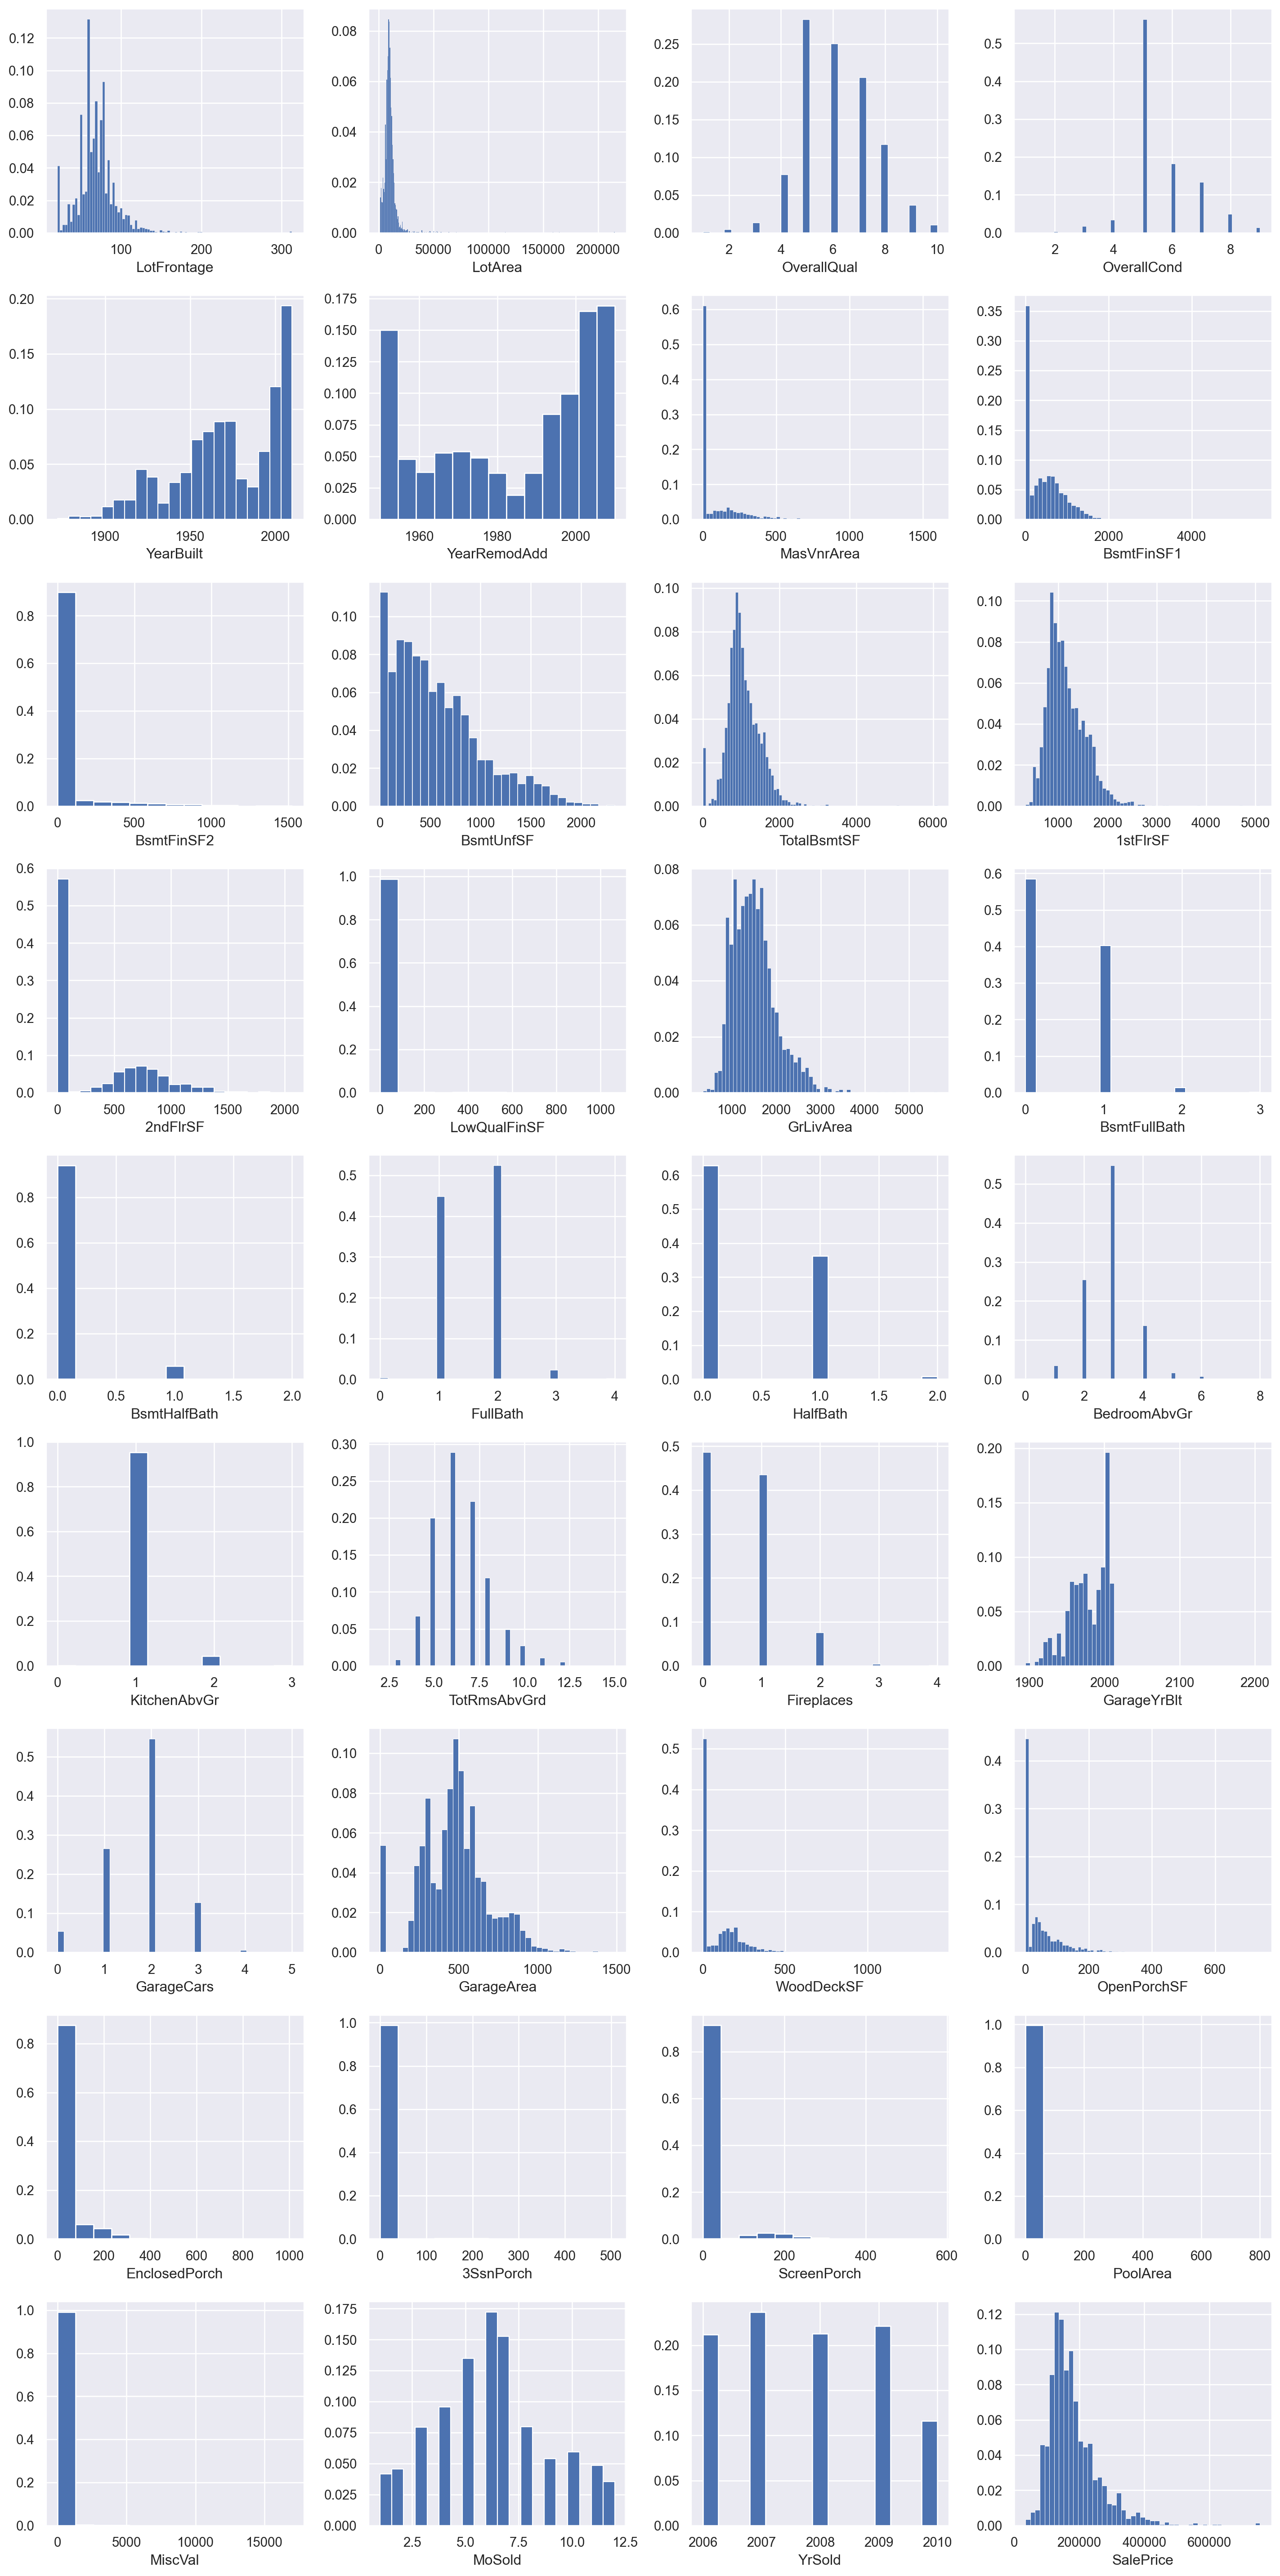

In [26]:
(
    so.Plot(quantitative_df)
    .pair(x=quantitative_df.columns, wrap=4)
    .add(so.Bars(alpha=1), so.Hist(stat='proportion', common_norm=False, common_bins=False))
    .share(x=False, y=False)
    .layout(size=(15, 30))
)

### Direct relationships with SalePrice

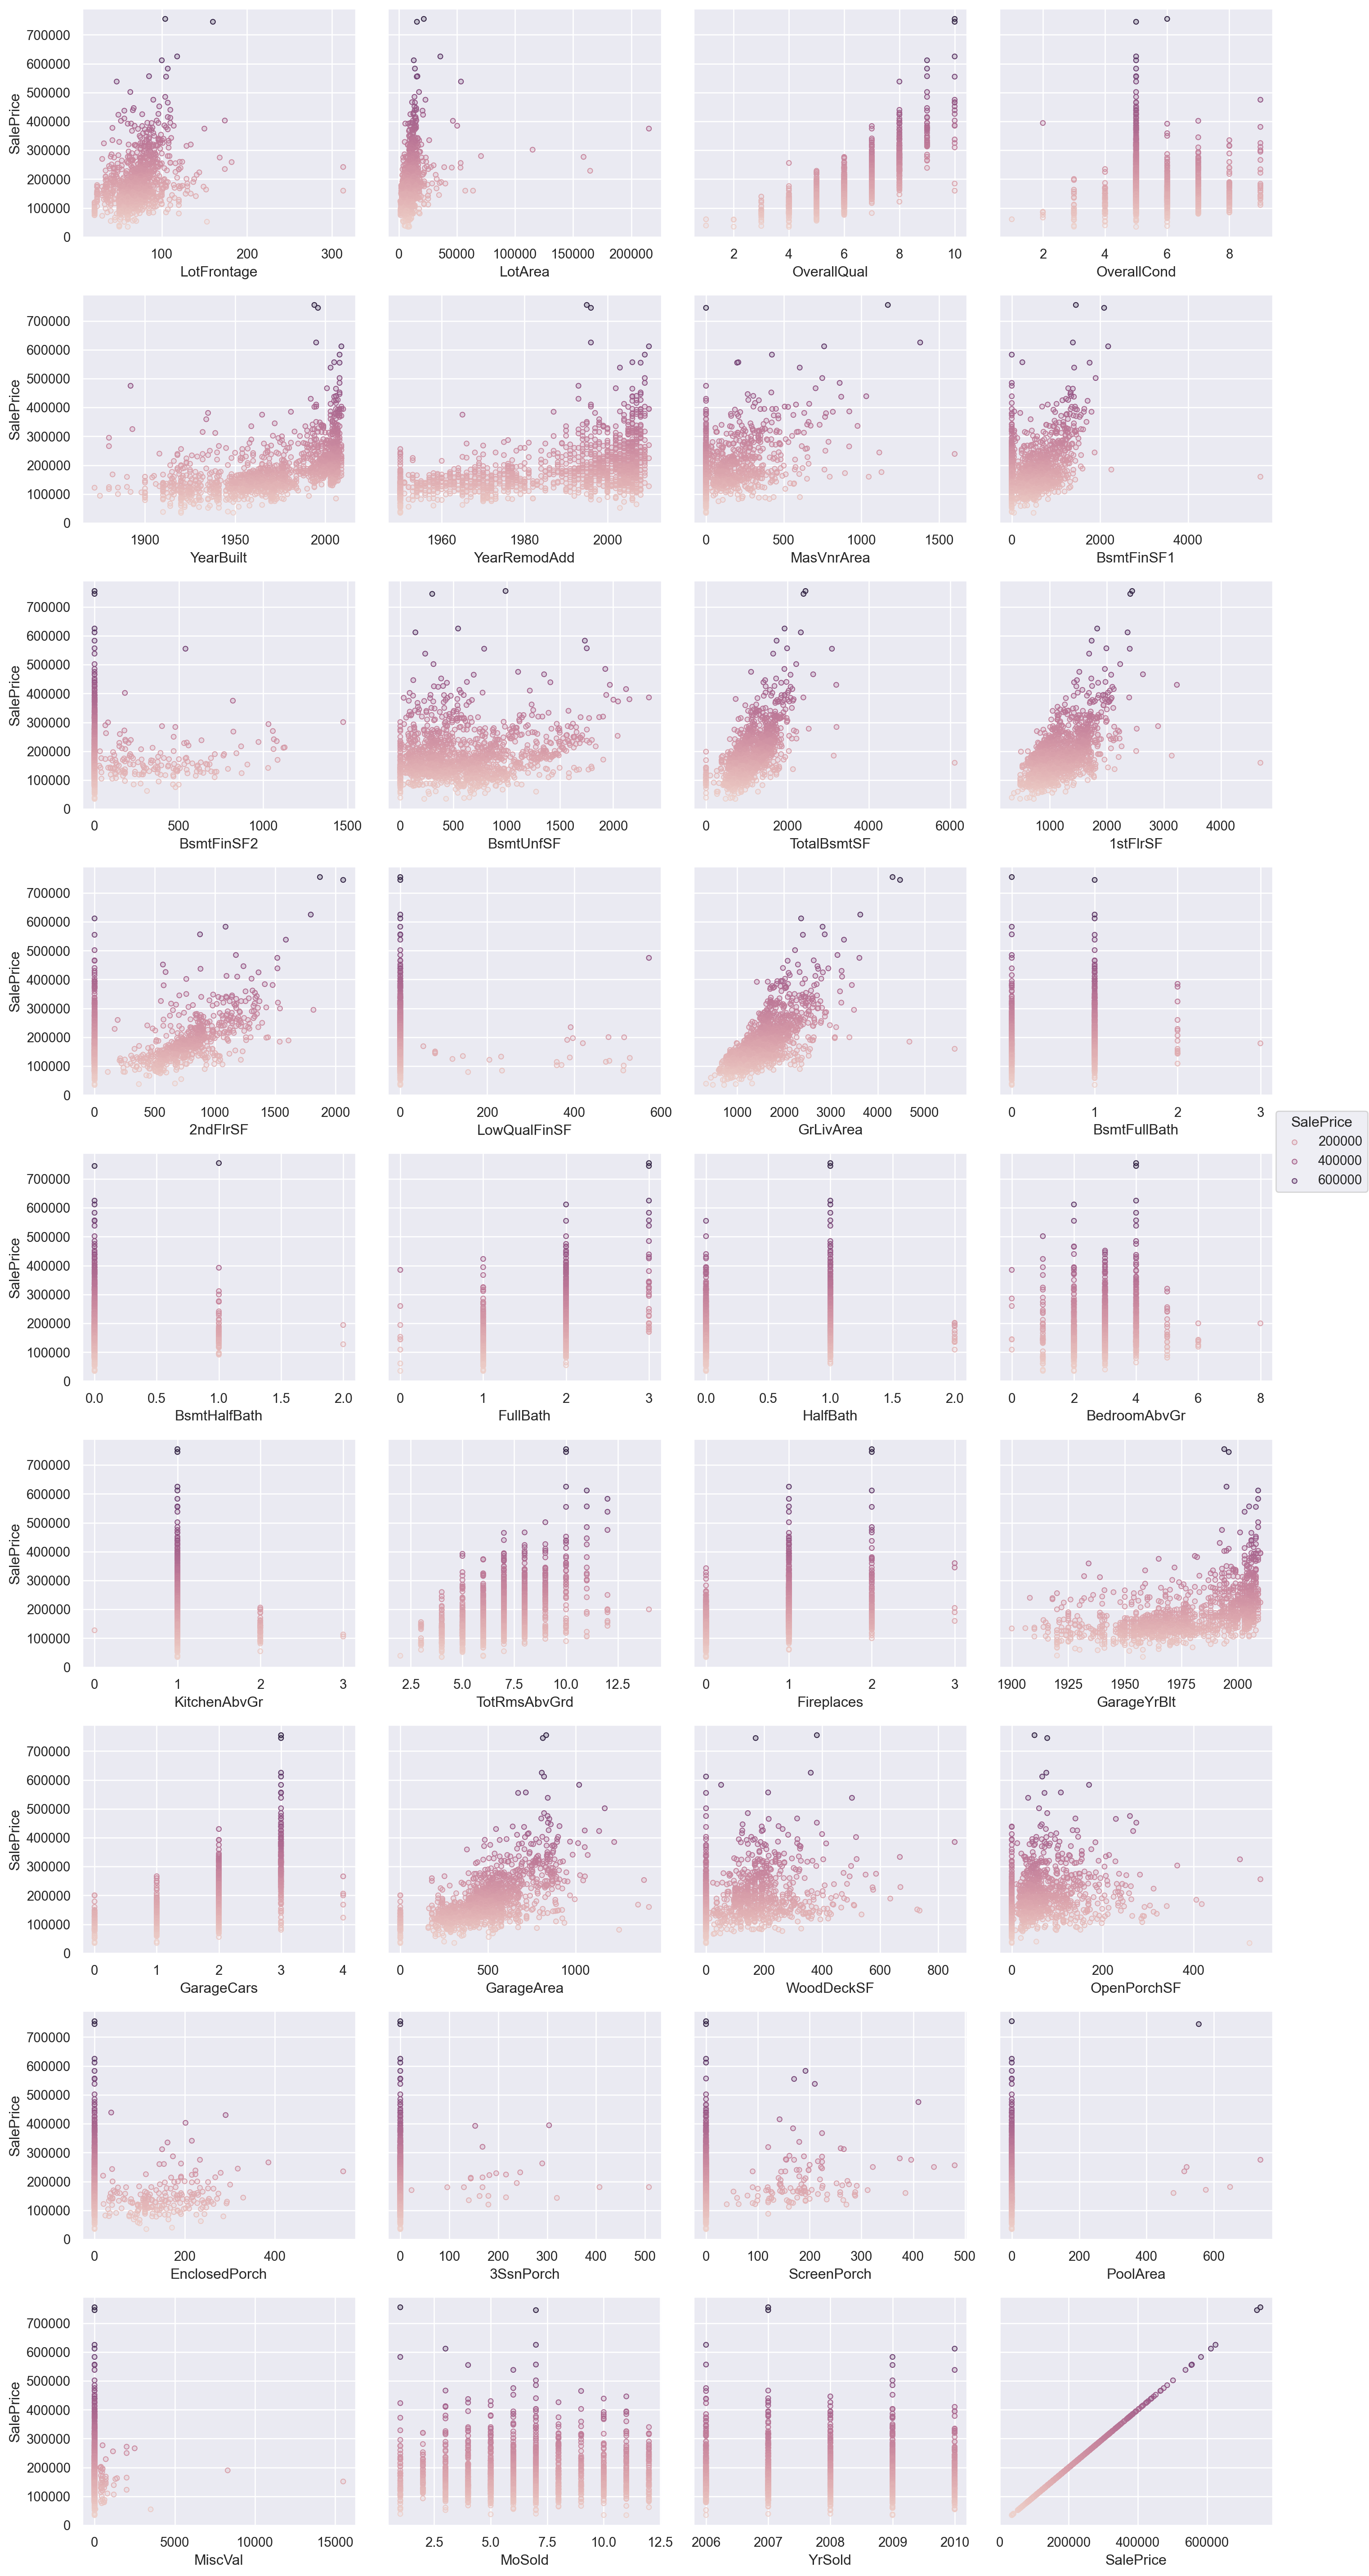

In [27]:
(
    so.Plot(train_df.select_dtypes('number'), y='SalePrice')
    .pair(x=train_df.select_dtypes('number').columns, wrap=4)
    .add(so.Dots(), color='SalePrice')
    .layout(size=(15, 30))
)

### Relations between predictors

In [28]:
quantitative_df.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

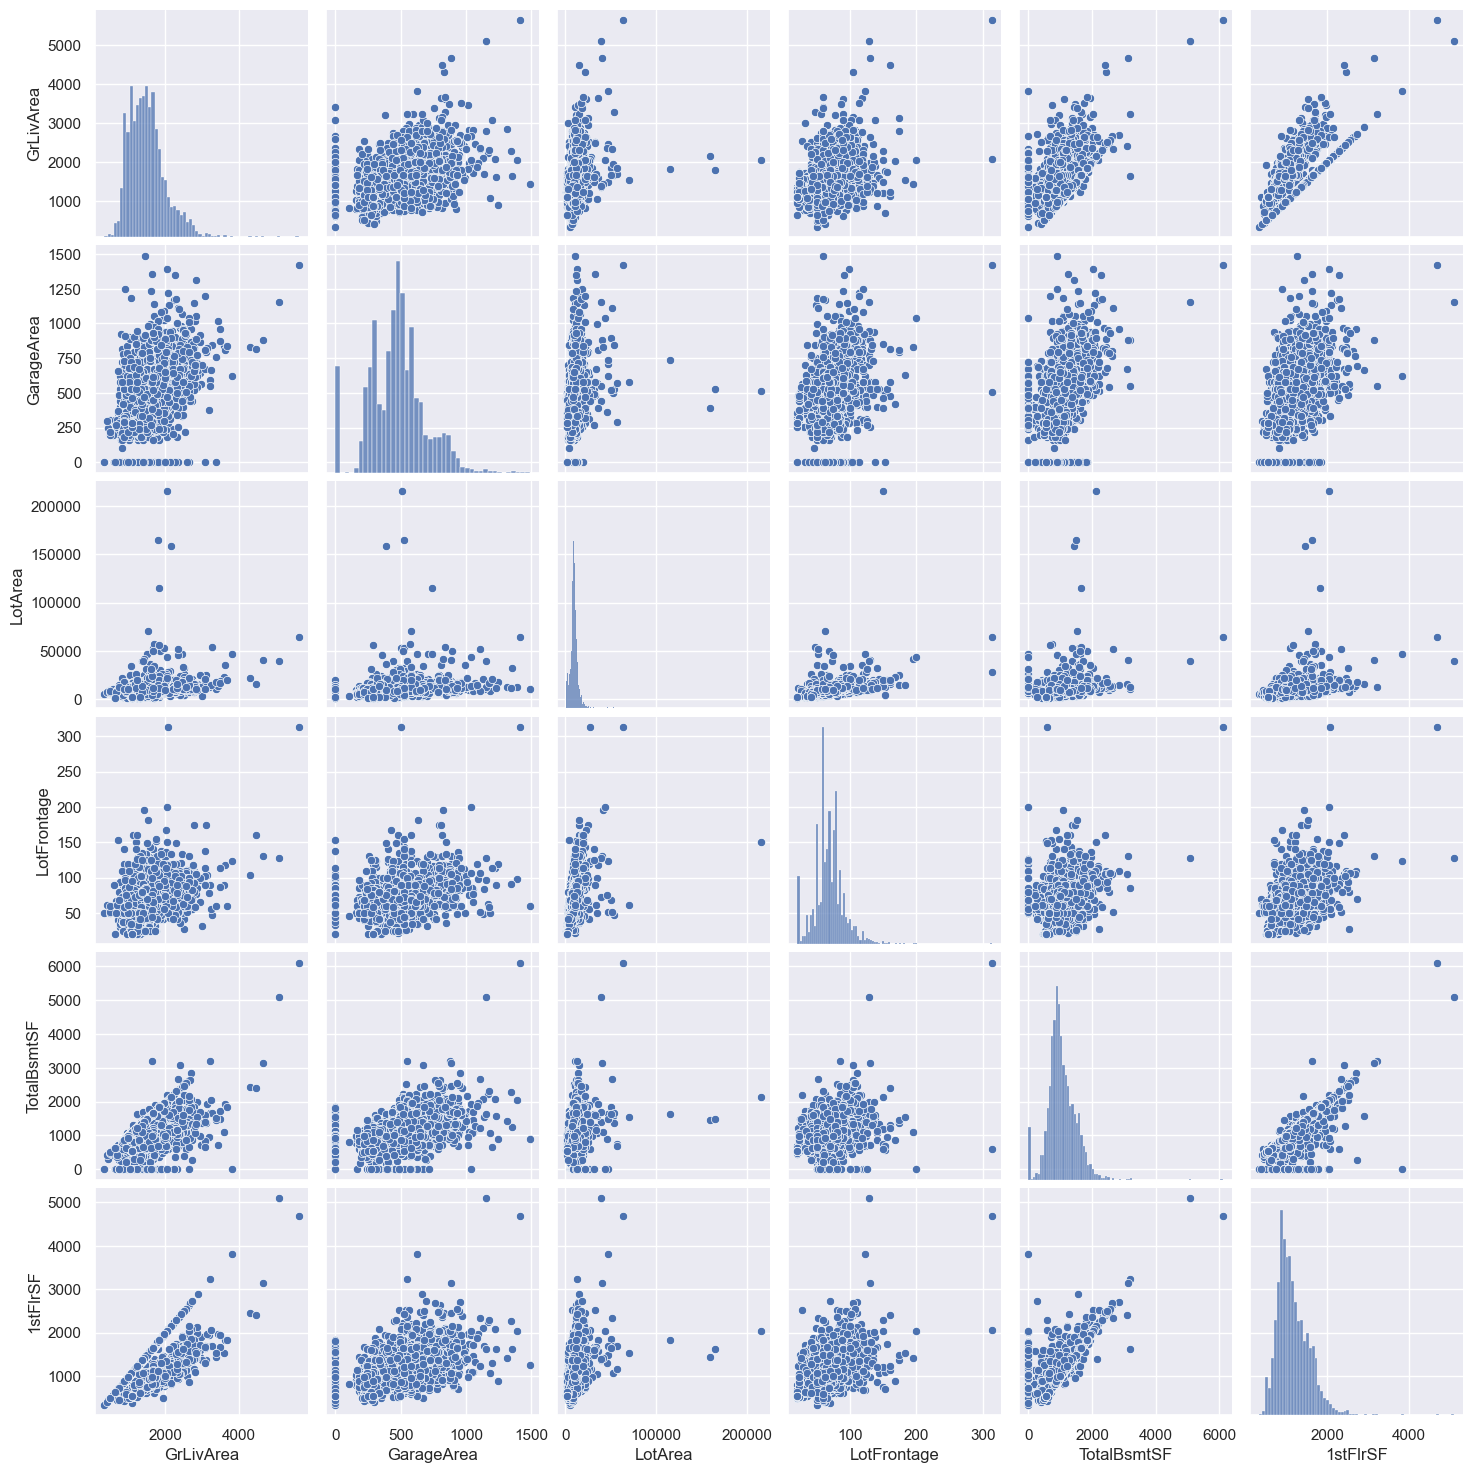

In [29]:
sns.pairplot(quantitative_df[['GrLivArea','GarageArea','LotArea','LotFrontage','TotalBsmtSF','1stFlrSF']])

### Skew

<Axes: >

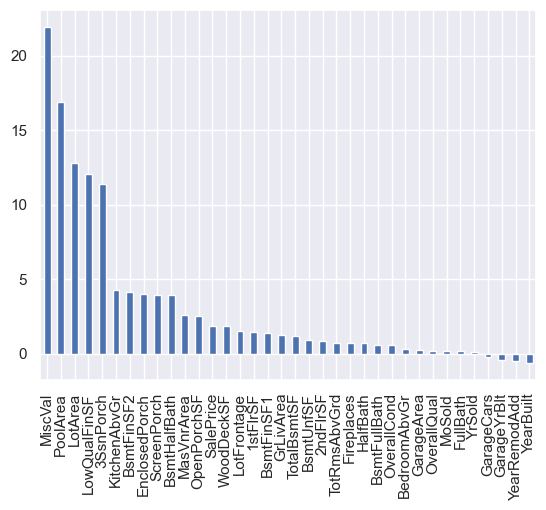

In [30]:
quantitative_df.skew().sort_values(ascending=False).plot.bar()

In [31]:
skewed = (
    quantitative_df.skew()
    .sort_values(ascending=False)
    .loc[lambda ser: ser.ge(2) | ser.le(-2)]
    .index
)
skewed_df = quantitative_df.loc[:, skewed]

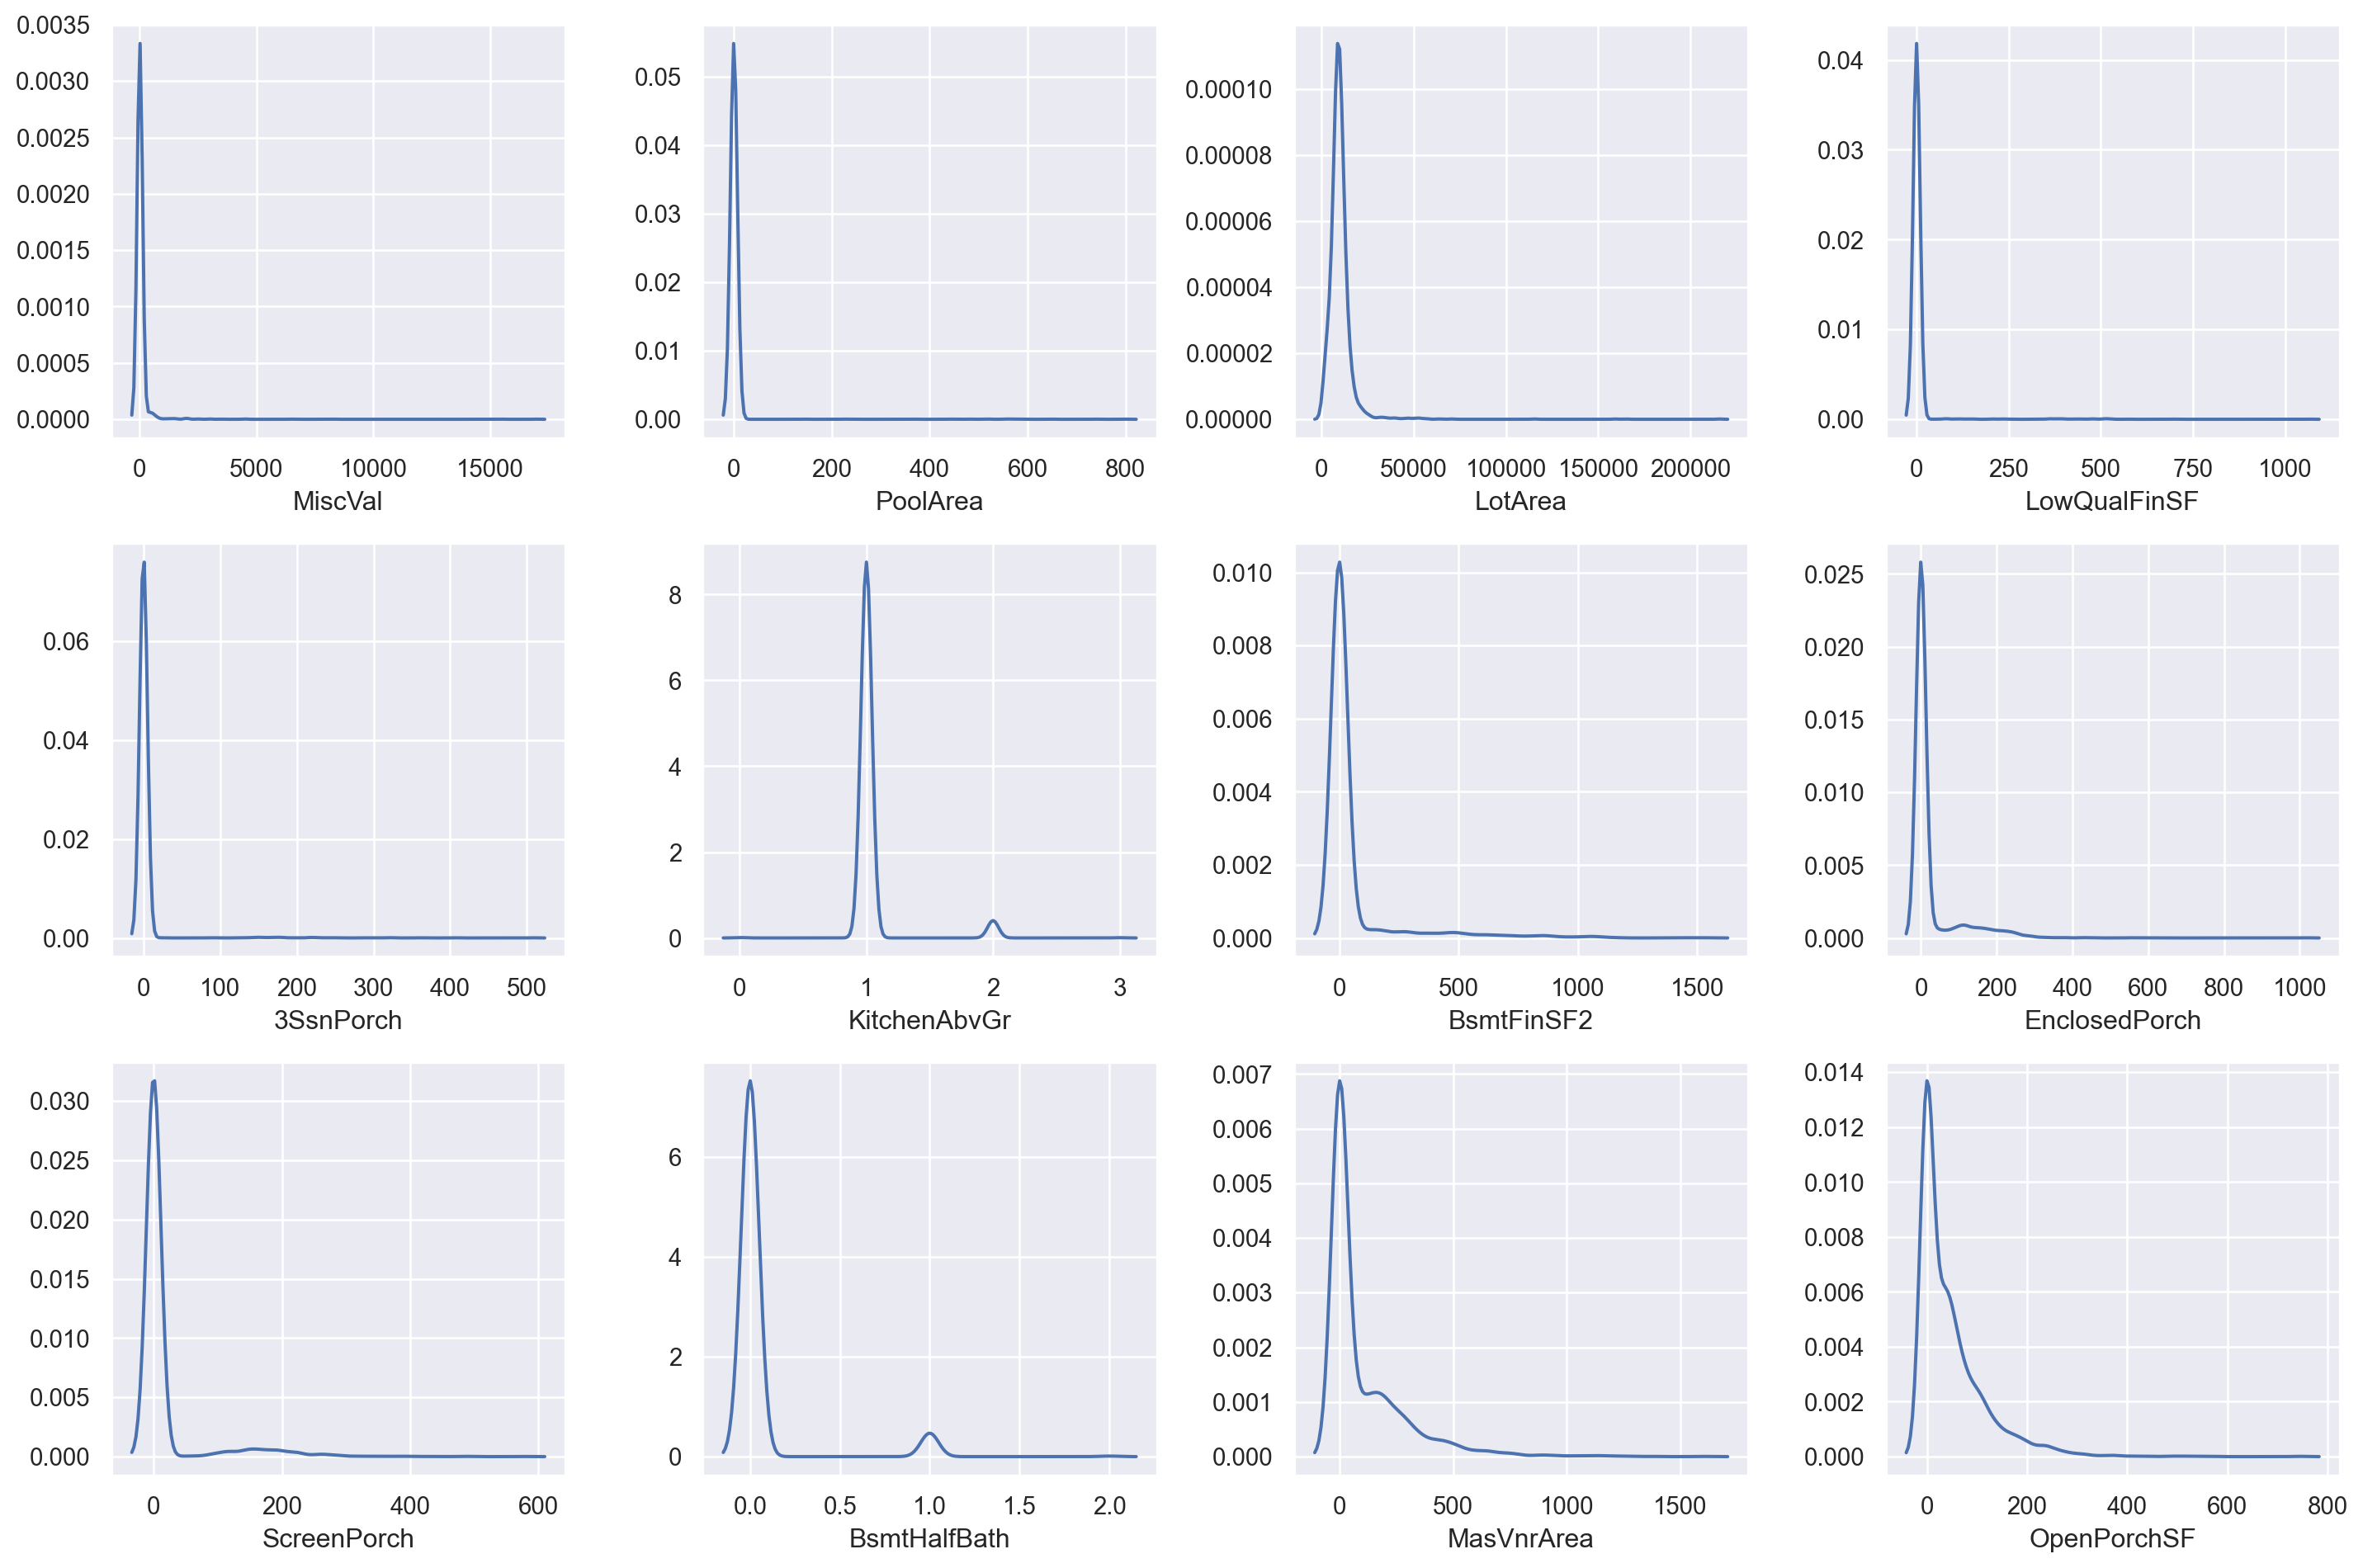

In [32]:
(
    so.Plot(skewed_df)
    .pair(x=skewed_df.columns, wrap=4)
    .add(so.Line(), so.KDE(common_norm=False, common_grid=False))
    .share(x=False, y=False)
    .layout(size=(15, 10))
)

## Categorical

<Axes: xlabel='MSSubClass', ylabel='SalePrice'>

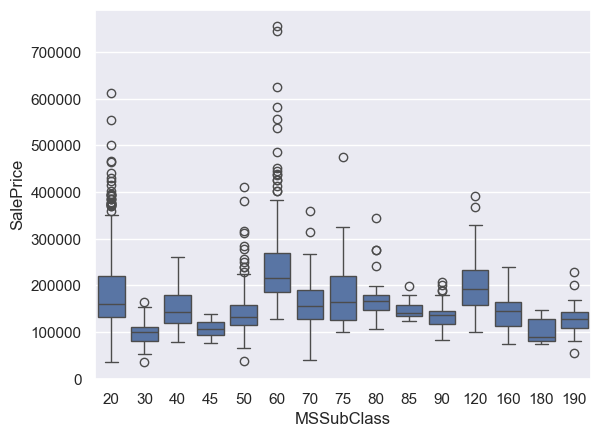

In [33]:
sns.boxplot(data=train_df.astype({'MSSubClass': 'int'}), x='MSSubClass', y='SalePrice')

<Axes: xlabel='MSZoning', ylabel='SalePrice'>

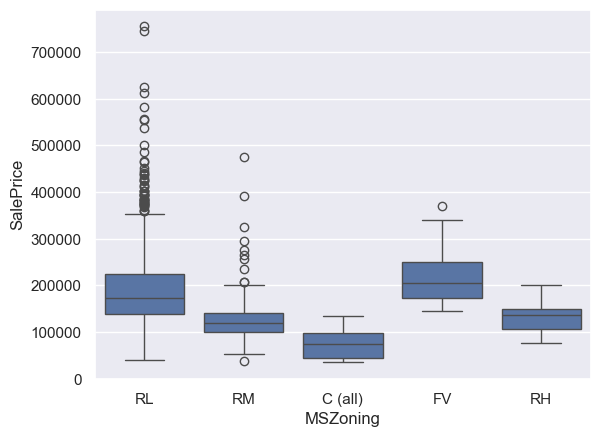

In [34]:
sns.boxplot(data=train_df, x='MSZoning', y='SalePrice')

<Axes: xlabel='LandSlope', ylabel='SalePrice'>

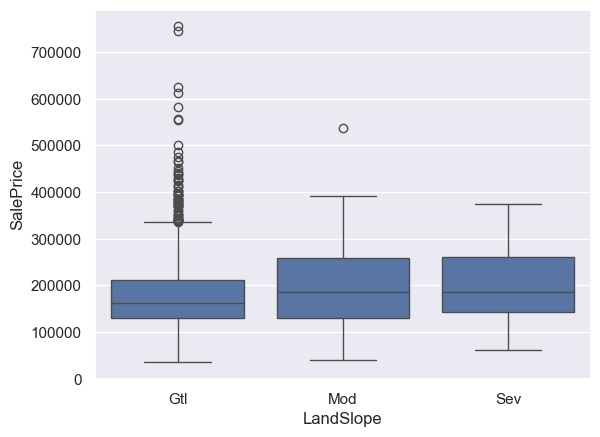

In [35]:
sns.boxplot(data=train_df, x='LandSlope', y='SalePrice')

# Dealing with missing values